In [143]:
import os
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *

import shutil
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

pd.set_option("max_colwidth", 100)
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

from google.cloud import storage

In [5]:
%%time

path = 'gs://msca-bdp-students-bucket/shared_data/kaihayden/final2'

tweets_df = spark.read.parquet(path)

CPU times: user 3.75 ms, sys: 0 ns, total: 3.75 ms
Wall time: 2.88 s


In [6]:
tweets_df.columns

['dt_date',
 'dt_datehour',
 'dt_day',
 'dt_hour',
 'dt_month',
 'dt_year',
 'ext_qt_user_id',
 'ext_rp_user_id',
 'ext_rt_id',
 'ext_rt_user_id',
 'is_original',
 'twt_continent',
 'twt_hashtags',
 'twt_id',
 'twt_importance',
 'twt_likes',
 'twt_quote_count',
 'twt_reply_count',
 'twt_retwt_count',
 'twt_text',
 'usr_desc',
 'usr_followers',
 'usr_id',
 'usr_location',
 'usr_name',
 'usr_tweet_count',
 'usr_verified']

### checking is_original field is working as intended

In [3]:
# %%time

# tweets_df.filter(col("is_original")==0).show(3, False, vertical=True)

In [4]:
# %%time

# tweets_df.filter(col("is_original")==1).show(3, False, vertical=True)

Identify the most prolific / influential Twitterers
- By message volume (original content)
- By message retweet (how often their messages are being retweeted)
- Who are these Twitterers (government entities / health organizations / news outlets / social media influencers / someone else)?
- Visualize the distribution of tweet / retweet volume by Twitterers and types of organizations


In [7]:
%%time

tweets_volume = tweets_df.filter(col('is_original')==1)\
                         .groupBy(['usr_id','usr_name']).agg(count('*').alias('count'),\
                                                             mean('twt_retwt_count').alias('avg_rts'),\
                                                             sum('twt_retwt_count').alias('tot_rts'))

CPU times: user 7.65 ms, sys: 583 µs, total: 8.24 ms
Wall time: 314 ms


# Identifying the most prolific Twitterers

### By message volume

In [8]:
%%time 

tweets_volume.orderBy('count', ascending=False).show(20)

+-------------------+---------------+-----+--------------------+-------+
|             usr_id|       usr_name|count|             avg_rts|tot_rts|
+-------------------+---------------+-----+--------------------+-------+
|         3219670842| njoyflyfishing|15340| 0.27392438070404174|   4202|
|          728894570| iWeller_health| 5176| 0.06375579598145285|    330|
|1283765688616628233|       galla_go| 4685|0.018996798292422627|     89|
|1269612893529444354|       newsbht1| 4519| 0.08563841557866785|    387|
|1015456945447170048|     HIREMAIDEA| 4346|  0.5402669121030833|   2348|
|1236273574895329281|      COVIDLive| 3683|  0.1278848764594081|    471|
|1191745846615957506|    PaperbirdsH| 3248|  0.0686576354679803|    223|
|1225793633342935043|       VippusaO| 2761| 0.20137631293009778|    556|
|1398687202507472904|    TittlePress| 2646|0.006802721088435374|     18|
|          283604227|    AndyVermaut| 2606| 0.02762854950115119|     72|
|1223569742364938240|      newsgang2| 2535|0.003550

### By message retweet (total and average)

In [9]:
%%time 

tweets_volume.filter(col("count")>1).orderBy('avg_rts', ascending=False).show(10, False)

+-------------------+--------------+-----+------------------+-------+
|usr_id             |usr_name      |count|avg_rts           |tot_rts|
+-------------------+--------------+-----+------------------+-------+
|1351332491425157121|itslinzzzz    |3    |19074.333333333332|57223  |
|1058807868         |GovRonDeSantis|4    |7294.0            |29176  |
|237845487          |GeorgeTakei   |2    |6571.5            |13143  |
|47751640           |AlexBuxton    |2    |5512.5            |11025  |
|13197402           |naftalibennett|2    |5125.5            |10251  |
|2281325286         |Techno_Fog    |2    |4734.0            |9468   |
|806344552718045184 |drsimonegold  |6    |4462.666666666667 |26776  |
|938507887713718272 |HSHQ          |11   |4264.363636363636 |46908  |
|18839785           |narendramodi  |4    |4262.25           |17049  |
|16927893           |RobertCStern  |3    |3890.6666666666665|11672  |
+-------------------+--------------+-----+------------------+-------+
only showing top 10 

In [8]:
%%time 

tweets_volume.orderBy('tot_rts', ascending=False).show(10, False)

+-------------------+---------------+-----+------------------+-------+
|usr_id             |usr_name       |count|avg_rts           |tot_rts|
+-------------------+---------------+-----+------------------+-------+
|39844876           |RWMaloneMD     |83   |2185.4457831325303|181392 |
|707231479047315456 |PeterSweden7   |61   |2108.72131147541  |128632 |
|878284831          |OccupyDemocrats|31   |2989.8709677419356|92686  |
|1679362640         |MichaelPSenger |83   |942.3975903614457 |78219  |
|755135678422327296 |BernieSpofforth|130  |559.5692307692308 |72744  |
|4765364386         |ChuckCallesto  |38   |1889.4473684210527|71799  |
|15392486           |disclosetv     |27   |2549.1111111111113|68826  |
|18831926           |DrEricDing     |79   |867.7088607594936 |68549  |
|3383159573         |doctor_oxford  |24   |2485.7916666666665|59659  |
|1351332491425157121|itslinzzzz     |3    |19074.333333333332|57223  |
+-------------------+---------------+-----+------------------+-------+
only s

### Who are these Twitterers?

In [10]:
tweet_avg_rts = tweets_volume.filter(col('count')>1).orderBy('avg_rts', ascending=False).limit(50).toPandas()

tweet_tot_rts = tweets_volume.orderBy('tot_rts', ascending=False).limit(50).toPandas()

In [11]:
top_avg_rts = list(tweet_avg_rts['usr_name'].unique())
top_tot_rts = list(tweet_tot_rts['usr_name'].unique())

In [12]:
print(len(list(set(top_avg_rts) & set(top_tot_rts)))) # in both lists
print(len(list(set(top_avg_rts) ^ set(top_tot_rts)))) # in just one list

13
74


In [17]:
a = set(top_avg_rts+top_tot_rts)
print(a)

{'zerohedge', 'narendramodi', 'FredPawle', 'EssexPR', 'DrTomFrieden', 'laurenboebert', 'atensnut', 'AskAnshul', 'GovRonDeSantis', 'RealCandaceO', 'CNN', 'nytimes', 'TheBabylonBee', 'Sasyity', 'catturd2', 'Notrossiter', 'BigBird', 'BernieSpofforth', 'EmeraldRobinson', 'kylegriffin1', 'RepThomasMassie', 'PeterSweden7', 'Liz_Wheeler', 'Techno_Fog', 'bryonq', 'drdavidsamadi', 'ElectionWiz', 'newsmax', 'DMinghella', 'RobertCStern', 'Jim_Jordan', 'mtgreenee', 'Khulood_Almani', 'RandPaul', 'DrEricDing', 'JamesMelville', 'EricSpracklen', 'JujuliaGrace', 'ClayTravis', 'kylenabecker', 'PierreKory', 'ChuckCallesto', 'DanPriceSeattle', 'DrEliDavid', 'MarinaPurkiss', 'Travistritt', 'David__Osland', 'CassyWearsHeels', 'RoArquette', 'itslinzzzz', 'doctor_oxford', 'Kukicat7', 'joncoopertweets', 'nathaliejacoby1', 'TruckerRandy', 'RWMaloneMD', 'Reuters', 'JackPosobiec', 'naftalibennett', 'tedcruz', 'drsimonegold', 'MichaelPSenger', 'gluboco', 'ksorbs', 'PrisonPlanet', 'DrSyedHaider', 'disclosetv', 'agi

In [19]:
other = ['AQUARlUSMARS','AlexBuxton','FredPawle','Sasyity','Notrossiter','bryonq','RobertCStern','itslinzzzz','Kukicat7','gluboco','hrIykoo','withorpe']

political = ['narendramodi','laurenboebert','GovRonDeSantis','EmeraldRobinson','RepThomasMassie','Jim_Jordan','RandPaul','ChuckCallesto','joncoopertweets',\
             'naftalibennett','tedcruz','mtgreenee']

medical = ['DrTomFrieden','drdavidsamadi','DrEricDing','JujuliaGrace','PierreKory','DrEliDavid','doctor_oxford','RWMaloneMD','drsimonegold','DrSyedHaider',\
           'NHSMillion',]

kol = ['AskAnshul','RealCandaceO','atensnut','BernieSpofforth','DMinghella','Khulood_Almani','JamesMelville','MarinaPurkiss','JackPosobiec',\
       'MichaelPSenger','PrisonPlanet','RobertKennedyJr','JordanSchachtel','EricMMatheny']

influencer = ['EricSpracklen','EssexPR','ClayTravis','DanPriceSeattle','kylenabecker','Travistritt','Liz_Wheeler','CassyWearsHeels','RoArquette',\
              'nathaliejacoby1','ksorbs','aginnt','GaryLineker','SadhguruJV','guygavrielkay','davidschneider','HSHQ','RealMattCouch','GeorgeTakei','TruckerRandy']

entertainment = ['TheBabylonBee','catturd2','BigBird','spike_nft']

coverage = ['ElectionWiz','Techno_Fog','zerohedge','disclosetv','OccupyDemocrats']

news_affiliated = ['kylegriffin1','PeterSweden7','LisaMarieBoothe','David__Osland','TimRunsHisMouth']

news_outlet = ['CNN','nytimes','newsmax','Reuters']

In [21]:
other_d = {k:'other' for k in other}
political_d = {k:'political' for k in political}
medical_d = {k:'medical' for k in medical}
kol_d = {k:'kol' for k in kol}
influencer_d = {k:'influencer' for k in influencer}
entertainment_d = {k:'entertainment' for k in entertainment}
coverage_d = {k:'coverage' for k in coverage}
news_affiliated_d = {k:'news_affiliated' for k in news_affiliated}
news_outlet_d = {k:'news_outlet' for k in news_outlet}

In [135]:
len_dict_avg = {'Other':3,
                'Political':5,
                'Medical':9,
                'Key Opinion Leader':12,
                'Influencer':8,
                'Entertainment':2,
                'Coverage':4,
                'News Affiliated':3,
                'News Outlet':4}

len_df_avg = pd.DataFrame(len_dict_avg, index=['Counts']).transpose()

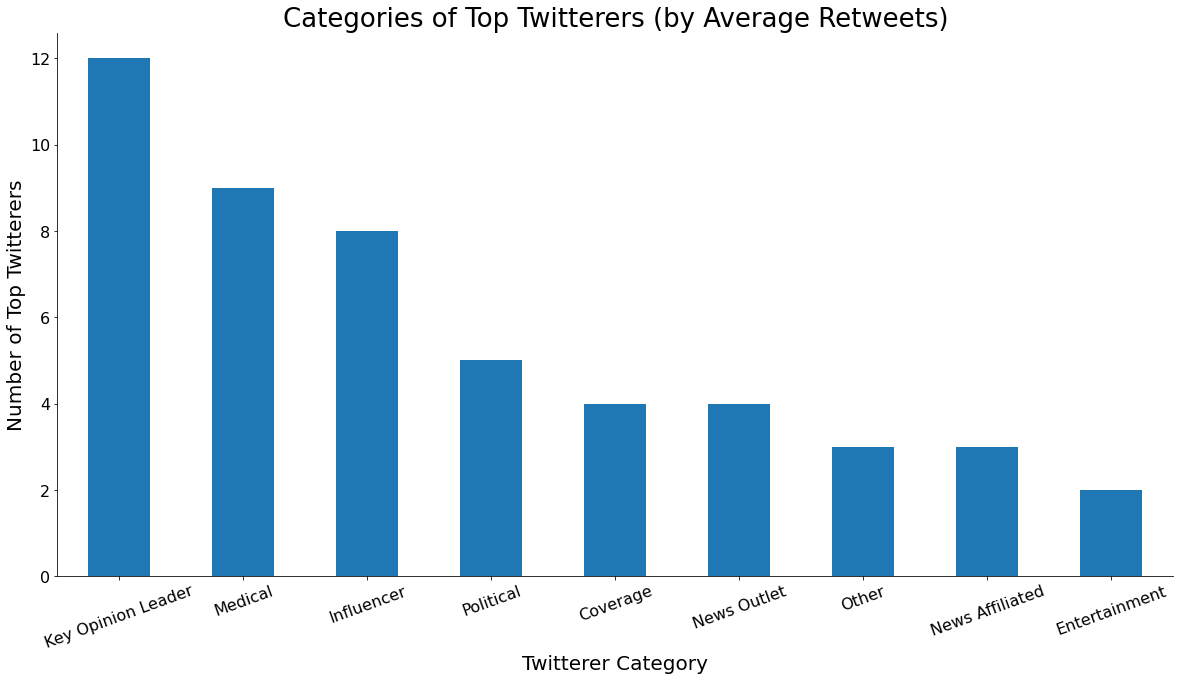

In [140]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

len_df_avg.sort_values(by='Counts',ascending=False).plot.bar(ax=ax,legend=None)

r_side = ax.spines["right"]
r_side.set_visible(False)
t_side = ax.spines["top"]
t_side.set_visible(False)

ax.tick_params(axis='x', rotation=20)

ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_ylabel("Number of Top Twitterers", fontsize=20)

ax.set_xlabel("Twitterer Category", fontsize=20)

ax.set_title('Categories of Top Twitterers (by Average Retweets)', fontsize=26)

plt.savefig('./graph2.png',bbox_inches='tight')
plt.show()

In [137]:
len_dict_tot = {'Other':10,
                'Political':9,
                'Medical':6,
                'Key Opinion Leader':3,
                'Influencer':14,
                'Entertainment':3,
                'Coverage':3,
                'News Affiliated':2,
                'News Outlet':0}

len_df_tot = pd.DataFrame(len_dict_tot, index=['Counts']).transpose()

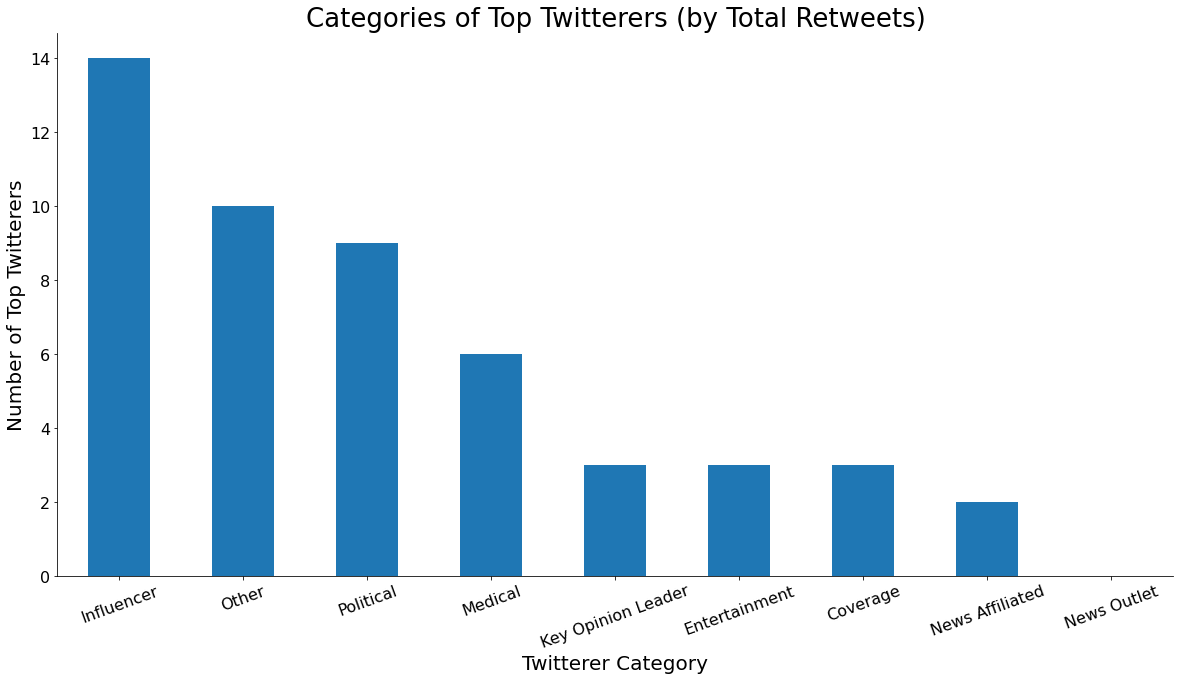

In [139]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

len_df_tot.sort_values(by='Counts',ascending=False).plot.bar(ax=ax,legend=None)

r_side = ax.spines["right"]
r_side.set_visible(False)
t_side = ax.spines["top"]
t_side.set_visible(False)

ax.tick_params(axis='x', rotation=20)

ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_ylabel("Number of Top Twitterers", fontsize=20)

ax.set_xlabel("Twitterer Category", fontsize=20)

ax.set_title('Categories of Top Twitterers (by Total Retweets)', fontsize=26)

plt.savefig('./graph1.png',bbox_inches='tight')
plt.show()

In [55]:
usr_dict = {}
usr_dict.update(other_d)
usr_dict.update(political_d)
usr_dict.update(medical_d)
usr_dict.update(kol_d)
usr_dict.update(influencer_d)
usr_dict.update(entertainment_d)
usr_dict.update(coverage_d)
usr_dict.update(news_affiliated_d)
usr_dict.update(news_outlet_d)

In [23]:
usr_df = pd.DataFrame.from_dict(usr_dict, orient='index').reset_index()
usr_df.rename(columns={'index': 'usr_name',
                       0: 'usr_type'},
              inplace=True)

In [24]:
tweet_avg_rts = tweet_avg_rts.merge(usr_df,on='usr_name',how='left')

In [25]:
tweet_tot_rts = tweet_tot_rts.merge(usr_df,on='usr_name',how='left')

### Top Twitterers by Average Retweets per Tweet

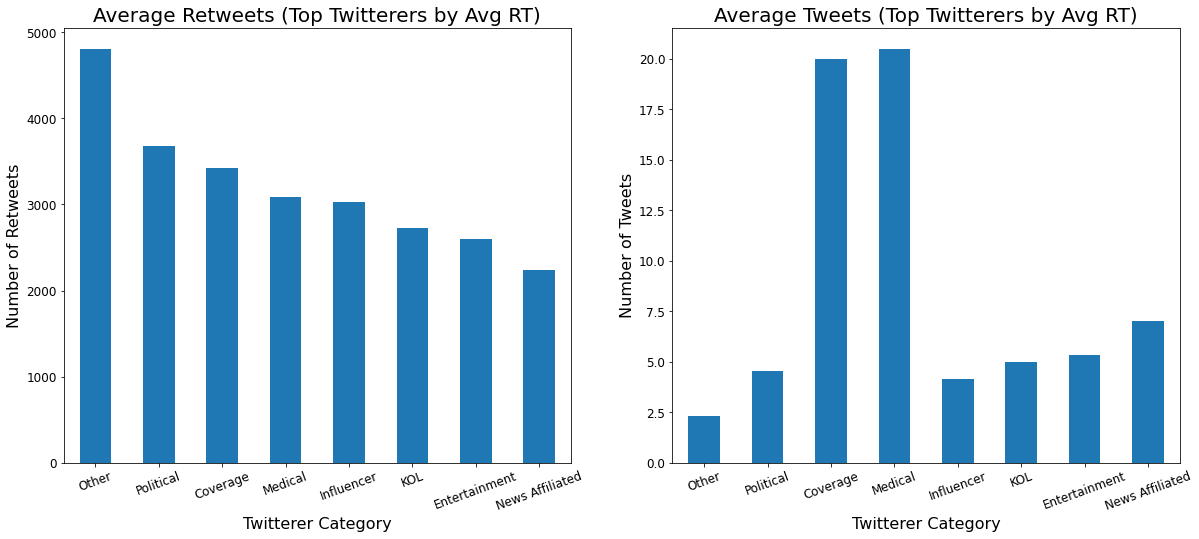

In [154]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,8))

tweet_avg_rts.groupby(['usr_type']).mean()['avg_rts']\
                                   .sort_values(ascending=False)\
                                   .plot.bar(ax=ax1)

tweet_avg_rts.groupby(['usr_type']).mean()['count']\
                                   .reindex(index = ['other','political','coverage','medical','influencer','kol','entertainment','news_affiliated'])\
                                   .plot.bar(ax=ax2)

ax1.set_xticklabels(['Other','Political','Coverage','Medical','Influencer','KOL','Entertainment','News Affiliated'])
ax2.set_xticklabels(['Other','Political','Coverage','Medical','Influencer','KOL','Entertainment','News Affiliated'])

ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

ax1.tick_params(axis='x', rotation=20)
ax2.tick_params(axis='x', rotation=20)

ax1.set_ylabel("Number of Retweets", fontsize=16)
ax2.set_ylabel("Number of Tweets", fontsize=16)

ax1.set_xlabel("Twitterer Category", fontsize=16)
ax2.set_xlabel("Twitterer Category", fontsize=16)

ax1.set_title('Average Retweets (Top Twitterers by Avg RT)', fontsize=20)
ax2.set_title('Average Tweets (Top Twitterers by Avg RT)', fontsize=20)

plt.savefig('./graph3.png',bbox_inches='tight')
plt.show()

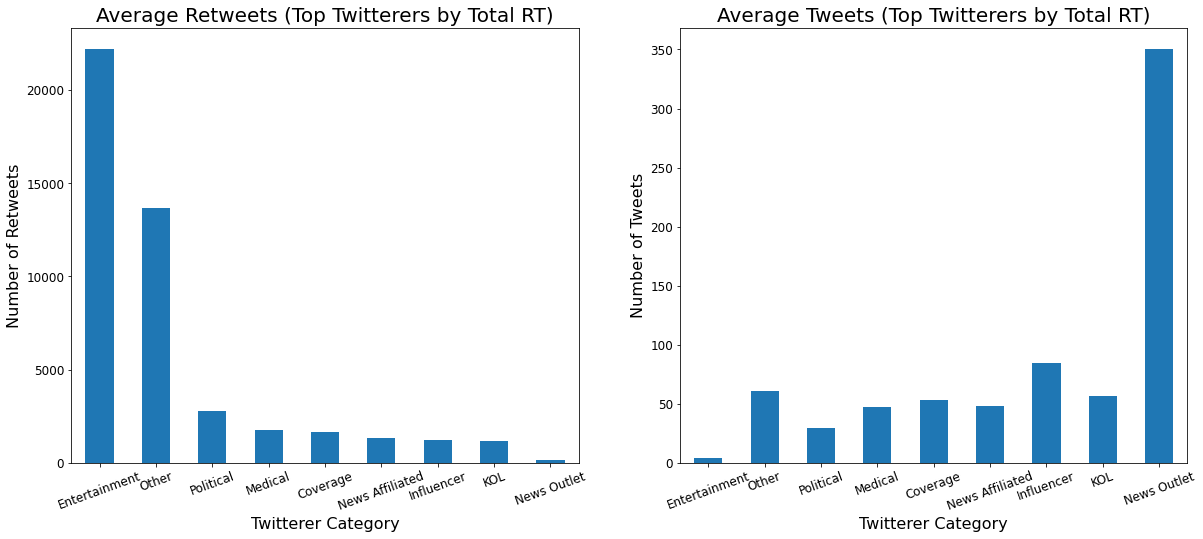

In [155]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,8))

tweet_tot_rts.groupby(['usr_type']).mean()['avg_rts']\
                                   .sort_values(ascending=False)\
                                   .plot.bar(ax=ax1)

tweet_tot_rts.groupby(['usr_type']).mean()['count']\
                                   .reindex(index = ['entertainment', 'other', 'political', 'medical', 'coverage', 'news_affiliated', 'influencer', 'kol', 'news_outlet'])\
                                   .plot.bar(ax=ax2)

ax1.set_xticklabels(['Entertainment', 'Other', 'Political', 'Medical', 'Coverage', 'News Affiliated', 'Influencer', 'KOL', 'News Outlet'])
ax2.set_xticklabels(['Entertainment', 'Other', 'Political', 'Medical', 'Coverage', 'News Affiliated', 'Influencer', 'KOL', 'News Outlet'])

ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

ax1.tick_params(axis='x', rotation=20)
ax2.tick_params(axis='x', rotation=20)

ax1.set_ylabel("Number of Retweets", fontsize=16)
ax2.set_ylabel("Number of Tweets", fontsize=16)

ax1.set_xlabel("Twitterer Category", fontsize=16)
ax2.set_xlabel("Twitterer Category", fontsize=16)

ax1.set_title('Average Retweets (Top Twitterers by Total RT)', fontsize=20)
ax2.set_title('Average Tweets (Top Twitterers by Total RT)', fontsize=20)

plt.savefig('./graph4.png',bbox_inches='tight')
plt.show()

In [157]:
tweet_tot_rts[tweet_tot_rts['usr_type']=='news_outlet']

,usr_id,usr_name,count,avg_rts,tot_rts,usr_type
23,1652541,Reuters,864,37.343750,32265,news_outlet
26,807095,nytimes,154,203.538961,31345,news_outlet
34,759251,CNN,182,151.423077,27559,news_outlet
46,20545835,newsmax,203,113.733990,23088,news_outlet


In [4]:
%%time

path = 'gs://msca-bdp-students-bucket/shared_data/kaihayden/final2'

tweets_df = spark.read.parquet(path)

CPU times: user 2.59 ms, sys: 708 µs, total: 3.3 ms
Wall time: 571 ms


In [5]:
tweets_df.show(5,False,vertical=True)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 dt_date         | 2021-11-03                                                                                                                                                                                                                                                                                              
 dt_datehour     | 2021-11-03 17:00:00                                                                                                                                                                                                                                                                                     
 dt_day          | 3                                